# Age

## Options for Processing Rules

-- Drop missing/inconsistent sex beneficiaries

-- Interested in 65+, drop people under 64 (so they can become 65 in that year)--check this point again

-- Assign death flag to extremely old or remove them if they reach a certain age? Truncating a certain age

-- After age 99 we will truncate and assign dead status flag at age 99 for all beneficiaries older than 99


* Exploring options to determine processing rules for age

In [1]:
## Load packages ----
import numpy as np
import pandas as pd
import sshtunnel
import psycopg2 as pg
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

/n/home_fasse/laurenflynn/.conda/envs/dorieh/lib/python3.10/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
## Open ssh tunnel to DB host ----
tunnel = sshtunnel.SSHTunnelForwarder(
    ('nsaph.rc.fas.harvard.edu', 22),
    ssh_username=f'{os.environ["MY_NSAPH_SSH_USERNAME"]}',
    ssh_private_key=f'{os.environ["HOME"]}/.ssh/id_rsa', 
    ssh_password=f'{os.environ["MY_NSAPH_SSH_PASSWORD"]}', 
    remote_bind_address=("localhost", 5432)
)

tunnel.start()

In [3]:
## Open connection to DB ----
connection = pg.connect(
    host='localhost',
    database='nsaph2',
    user=f'{os.environ["MY_NSAPH_DB_USERNAME"]}',
    password=f'{os.environ["MY_NSAPH_DB_PASSWORD"]}', 
    port=tunnel.local_bind_port
)

## Query age

## Investigate combination of age and dual

## Investigate combinations of age and original reason for entitlement

In [4]:
sql_query = f"""SELECT bene_id, sex, (first_enrollment_year - yob) AS youngest_age, (last_enrollment_year - yob) AS oldest_age FROM medicare.beneficiaries;"""

In [5]:
sql_query

'SELECT bene_id, sex, (first_enrollment_year - yob) AS youngest_age, (last_enrollment_year - yob) AS oldest_age FROM medicare.beneficiaries;'

In [6]:
## Request query ----
df = pd.read_sql_query(sql_query, connection, index_col = 'bene_id').reset_index()

Below we look at the sex of the beneficiaries, where 0=unknown, 1=male, and 2=female. If a beneficiary has varying records of sex over the years, the sex will be denoted as a concatenation of these values (e.g. if some years the beneficiary sex was unknown and other years it was female, it would be '0,2'). Any value less than 10 will be denoted with "\*\*" for Medicare data use compliance.

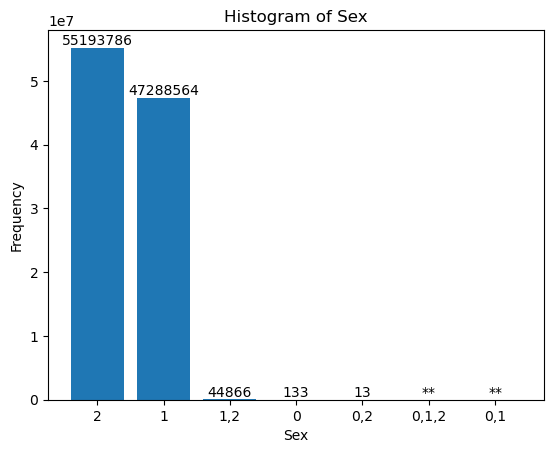

In [8]:
unique_sex = df.sex.unique()
unique_sex_counts = df['sex'].value_counts()

plt.bar(range(len(unique_sex)), unique_sex_counts, tick_label=unique_sex)

# Add value counts on top of the bars
for i, count in enumerate(unique_sex_counts):
    if count > 10:
        plt.text(i, count, str(count), ha='center', va='bottom')
    else:
        plt.text(i, count, "**", ha='center', va='bottom')

# Add labels and title
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.title('Histogram of Sex')

# Display the histogram
plt.show()

Below we explore the age that a beneficiary first enrolls in Medicare (the youngest age for which they are included in Medicare). Many beneficiaries enroll at age 65 or older, but there is a substantial portion of beneficiaries that enroll before age 65 due to disabilities or end stage renal disease.

## Check if the sex coding mixups were concentrated in a particular year/month/state

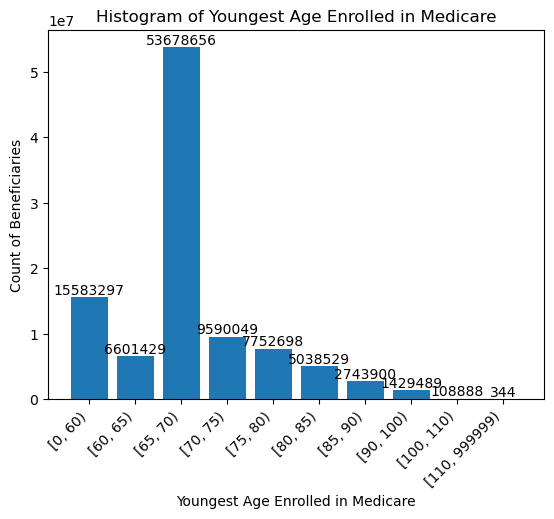

In [9]:
# Custom age ranges for bins
custom_bins = [0, 60, 65,70,75,80,85,90,100,110,999999]  # Adjust the age ranges as desired

# Bin the youngest_age column and assign it to a new column 'age_group'
df['age_group'] = pd.cut(df['youngest_age'], bins=custom_bins, right=False)

# Group by age_group and calculate the count
age_group_counts = df['age_group'].value_counts().sort_index()

# Plot the histogram with sorted age groups
plt.bar(range(len(age_group_counts)), age_group_counts, tick_label=age_group_counts.index)

# Add value counts on top of the bars
for i, count in enumerate(age_group_counts):
    if count > 10:
        plt.text(i, count, str(count), ha='center', va='bottom')
    else:
        plt.text(i, count, "**", ha='center', va='bottom')

# Add labels and title
plt.xlabel('Youngest Age Enrolled in Medicare')
plt.ylabel('Count of Beneficiaries')
plt.title('Histogram of Youngest Age Enrolled in Medicare')

# Sort the x-axis labels
plt.xticks(range(len(age_group_counts)), age_group_counts.index, rotation=45, ha='right')

# Display the histogram
plt.show()

Next we will investigate the oldest age that a beneficiary is enrolled in Medicare. Very old ages are likely a clerical error and may be the results of deaths that were not recorded.

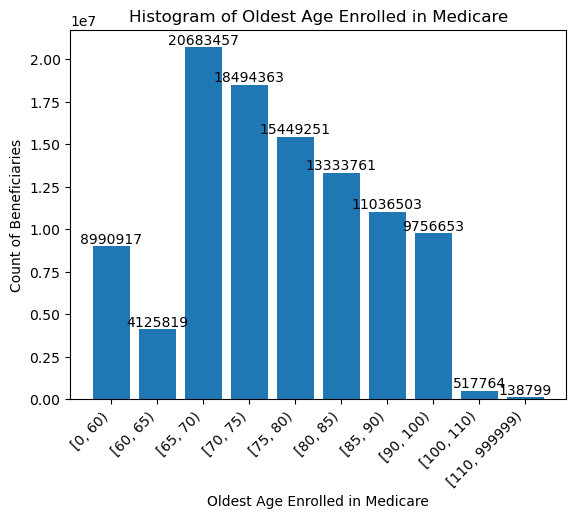

In [10]:
# Custom age ranges for bins
custom_bins = [0, 60, 65,70,75,80,85,90,100,110,999999]
# Adjust the age ranges as desired

# Bin the oldest_age column and assign it to a new column 'age_group'
df['age_group'] = pd.cut(df['oldest_age'], bins=custom_bins, right=False)

# Group by age_group and calculate the count
age_group_counts = df['age_group'].value_counts().sort_index()

# Plot the histogram with sorted age groups
plt.bar(range(len(age_group_counts)), age_group_counts, tick_label=age_group_counts.index)

# Add value counts on top of the bars
for i, count in enumerate(age_group_counts):
    if count > 10:
        plt.text(i, count, str(count), ha='center', va='bottom')
    else:
        plt.text(i, count, "**", ha='center', va='bottom')

# Add labels and title
plt.xlabel('Oldest Age Enrolled in Medicare')
plt.ylabel('Count of Beneficiaries')
plt.title('Histogram of Oldest Age Enrolled in Medicare')

# Sort the x-axis labels
plt.xticks(range(len(age_group_counts)), age_group_counts.index, rotation=45, ha='right')

# Display the histogram
plt.show()

In [11]:
# Check if youngest_age is less than oldest_age
invalid_ages = df['youngest_age'] > df['oldest_age']

# Count the number of rows where ages are valid
invalid_count = invalid_ages.sum()

# Print the result
print(f"Number of invalid rows: {invalid_count}")


Number of invalid rows: 0


We can see above that there are no beneficiaries queried where the oldest age is younger than the youngest age enrolled in Medicare, which indicates appropriate data cleaning steps have been implemented in data ingestion to avoid this. We will next investigate individuals with extremely old ages included in Medicare. In the U.S 2020 Census, there were 80,139 individuals older than age 100, and in the 2010 Census, there were just 53,364 individuals older than age 100 (https://www.census.gov/topics/population/older-aging.html). According to https://en.wikipedia.org/wiki/List_of_American_supercentenarians, there are only 26 individuals older than age 115 in America. 

In [12]:
# Check if youngest_age is less than oldest_age
invalid_ages = df['oldest_age'] > 100

# Count the number of rows where ages are valid
invalid_count = invalid_ages.sum()

# Print the result
print(f"Number of individuals older than 100: {invalid_count}")


# Check if youngest_age is less than oldest_age
invalid_ages = df['oldest_age'] > 115

# Count the number of rows where ages are valid
invalid_count = invalid_ages.sum()

# Print the result
print(f"Number of individuals older than 115: {invalid_count}")


Number of individuals older than 100: 466334
Number of individuals older than 115: 121300


We can see that there are far more individuals older than age 100 and older than age 115 in our Medicare sample. This indicates that there is an error in data collection and/or data processing. This issue is known within Medicare https://resdac.org/videos/sources-and-use-medicare-enrollment-information-0 16:00

In [13]:
sql_query = f"""SELECT ben.bene_id, ben.sex, (ben.first_enrollment_year - ben.yob) AS youngest_age, (ben.last_enrollment_year - ben.yob) AS oldest_age, ben.orec, en.dual FROM medicare.beneficiaries AS ben LEFT JOIN medicare.enrollments  AS en ON ben.bene_id=en.bene_id;"""

In [14]:
sql_query

'SELECT ben.bene_id, ben.sex, (ben.first_enrollment_year - ben.yob) AS youngest_age, (ben.last_enrollment_year - ben.yob) AS oldest_age, ben.orec, en.dual FROM medicare.beneficiaries AS ben LEFT JOIN medicare.enrollments  AS en ON ben.bene_id=en.bene_id;'

In [ ]:
## Request query ----
df2 = pd.read_sql_query(sql_query, connection, index_col = 'bene_id').reset_index()

In [ ]:
df2.head()